In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("../../")

In [ ]:
from tokenizers import Tokenizer
import sys

import matplotlib.pyplot as plt
import numpy as np
import collections
import torch

from ChEmbed.data import chembldb, datasets, chembed_tokenize
from ChEmbed.training import trainer
from ChEmbed.modules import simple_rnn
import attr

from ChEmbed import plots, utilities

from transformers.tokenization_utils_fast import PreTrainedTokenizerFast
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

Disabling PyTorch because PyTorch >= 2.1 is required but found 2.0.0
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [1]:
def simple_generate(prefix, num_chars, model, char_to_idx_mapping, idx_to_char_mapping, temperature = 0.0, device=None):
    """
    Simple character-by-character generation function.
    """

    def decode_indices_to_string(encoded_indices: list, idx_to_char_mapping: dict[int, str]):
        decoded = ''.join([idx_to_char_mapping[int(inx)] for inx in encoded_indices])
        return decoded

    def encode_string_to_indices(smiles_string: str, char_to_idx_mapping: dict[str, int]):
        encoded = [char_to_idx_mapping[c] for c in smiles_string]
        return encoded

    model.eval()
    generated = prefix
    
    with torch.no_grad():
        for i in range(num_chars):
            # Encode current text
            encoded = torch.nn.functional.one_hot(torch.tensor(encode_string_to_indices(generated, char_to_idx_mapping)), num_classes=len(char_to_idx_mapping))
            input_tensor = torch.tensor(encoded, device=device, dtype=torch.float32)
            
            # Get prediction
            output = model(input_tensor.unsqueeze(0))  # Add batch dim
            
            # Get most likely next token
            if temperature > 0:
                # Apply temperature scaling
                output = output / temperature
                probabilities = torch.softmax(output, dim=-1)
                next_token = torch.multinomial(probabilities[0, -1, :], num_samples=1).item()
            else:
                # Default to argmax if temperature is 0
                next_token = output[0, -1, :].argmax().item()
            
            # Decode and append
            next_char = decode_indices_to_string([next_token], idx_to_char_mapping)
            generated += next_char
            
            # print(f"Step {i+1}: Added '{next_char}' -> '{generated}'")
            
    return generated

In [ ]:
chembl_raw = chembldb.ChemblDBChemreps()
chembl_smiles = chembl_raw._load_or_download()["canonical_smiles"].to_list()

In [30]:
tokenizer = chembed_tokenize.load_chembed_tokenizer(filepath = "../data/tokenizers/tokenizer-chembldb-16-06-2025.json")

In [ ]:
# chembl_dataset = datasets.SMILESDataset(
#     smiles_list = chembl_smiles,
#     tokenizer = tokenizer
# )

# chembl_mini = datasets.SMILESDataset(
#     smiles_list = chembl_smiles[:5000],
#     tokenizer = tokenizer
# )

In [ ]:
chembl_mini = datasets.SMILESDatasetContinuous(
    smiles_list = chembl_smiles[:5000],
    tokenizer = tokenizer,
    length = 65,
)

In [33]:
print(chembl_mini[0][0].shape)
print(chembl_mini[0][1].shape)

torch.Size([65, 1029])
torch.Size([65])


In [34]:
# print(predict("C=O", 30, model, chembl_mini, device="cpu"))

In [35]:
model = simple_rnn.simpleRNN(
    # Mandatory
    num_hiddens = 128,
    vocab_size = len(tokenizer),
    # tuning
    learning_rate = 0.01,
    weight_decay = 0.05
)

In [36]:
batch = next(iter(chembl_mini.train_dataloader()))
print(batch[0].shape)
print(batch[1].shape)

# [batch_size, seq_len, vocab_size]
# [batch_size, seq_len]

torch.Size([128, 65, 1029])
torch.Size([128, 65])


In [37]:
test_smiles = "CN=C=O"
smiles_one_hot = chembl_mini.encode_smiles_to_one_hot(test_smiles)

outputs = model(smiles_one_hot.unsqueeze(0))

In [38]:
print(smiles_one_hot.shape)
print(outputs.shape)

torch.Size([65, 1029])
torch.Size([1, 65, 1029])


In [39]:
print(chembl_mini.tokenizer.decode(smiles_one_hot.argmax(1).tolist()))
print(chembl_mini.tokenizer.decode(outputs.squeeze().argmax(1).tolist()))

CN = C = O <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
c7 Oc2cc CCc3ccccc3 CCCO2 NCCC COC N1CCCC1 c7 N1CCCC1 N1CCCC1 COC N1CCCC1 N1CCCC1 COC N1CCCC1 N1CCCC1 N1CCCC1 N1CCCC1 N1CCCC1 N1CCCC1 N1CCCC1 N1CCCC1 N1CCCC1 N1CCCC1 N1CCCC1 N1CCCC1 N1CCCC1 N1CCCC1 N1CCCC1 N1CCCC1 N1CCCC1 N1CCCC1 COC N1CCCC1 N1CCCC1 N1CCCC1 N1CCCC1 N1CCCC1 c7 N1CCCC1 N1CCCC1 N1CCCC1 N1CCCC1 N1CCCC1 N1CCCC1 N1CCCC1 N1CCCC1 N1CCCC1 N1CCCC1 N1CCCC1 N1CCCC1 N1CCCC1 N1CCCC1 N1CCCC1 N1CCCC1 N1CCCC1 N1CCCC1 COC N1CCCC1 N1CCCC1 N1CCCC1 COC N1CCCC1 N1CCCC1 N1CCCC1


In [40]:
generate_sequence(
    prefix="C=O",
    num_chars=30,
    model=model,
    dataset=chembl_mini,
    device="cpu",
    temperature=0.01
)

/tmp/ipykernel_115130/478519445.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = torch.tensor(current_encoded, device=device, dtype=torch.float32)


'C=Oncnc21c2C1A1CSN1C1OCcccc1C3CCNc5nc3nc5NCc1ccco1ACCOCCOnc3ccc5O'

In [41]:

# Test the generation function
print("Testing generation with trained model:")
result = simple_generate("C=O", 5, model, chembl_mini, device="cpu")
print(f"Final result: {result}")

Testing generation with trained model:
Step 1: Added 'NCCC' -> 'C=ONCCC'
Step 2: Added 'COC' -> 'C=ONCCCCOC'
Step 3: Added 'CCCO2' -> 'C=ONCCCCOCCCCO2'
Step 4: Added 'CCCN' -> 'C=ONCCCCOCCCCO2CCCN'
Step 5: Added 'COC' -> 'C=ONCCCCOCCCCO2CCCNCOC'
Final result: C=ONCCCCOCCCCO2CCCNCOC


/tmp/ipykernel_115130/1838301241.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_tensor = torch.tensor(encoded, device=device, dtype=torch.float32)


In [43]:
model_trainer = trainer.Trainer(max_epochs=32, init_random=None, clip_grads_norm=1.0)
model_trainer.fit(model, chembl_mini)

Epoch 1/32: Train Loss: 4.2166, Val Loss: 2.3359
Epoch 2/32: Train Loss: 2.5454, Val Loss: 2.0588
Epoch 3/32: Train Loss: 2.4183, Val Loss: 1.9397
Epoch 4/32: Train Loss: 2.3497, Val Loss: 1.9340
Epoch 5/32: Train Loss: 2.3593, Val Loss: 1.9585
Epoch 6/32: Train Loss: 2.3782, Val Loss: 1.9924
Epoch 7/32: Train Loss: 2.3953, Val Loss: 2.0074
Epoch 8/32: Train Loss: 2.3943, Val Loss: 1.9700
Epoch 9/32: Train Loss: 2.3734, Val Loss: 1.9619
Epoch 10/32: Train Loss: 2.3842, Val Loss: 2.0148
Epoch 11/32: Train Loss: 2.3900, Val Loss: 1.9771
Epoch 12/32: Train Loss: 2.3856, Val Loss: 2.0287
Epoch 13/32: Train Loss: 2.4067, Val Loss: 2.0038


KeyboardInterrupt: 

NameError: name 'model' is not defined

In [20]:
generate_sequence(
    prefix="C=O",
    num_chars=30,
    model=model,
    dataset=chembl_mini,
    device="cuda",
    temperature=0.1
)

/tmp/ipykernel_115130/478519445.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = torch.tensor(current_encoded, device=device, dtype=torch.float32)


'C=O)[C@H](O)[C@H](O)[C@H](C)[C@H]'

In [21]:
generate_sequence(
    prefix="C1",
    num_chars=30,
    model=model,
    dataset=chembl_mini,
    device="cuda",
    temperature=0.1
)

/tmp/ipykernel_115130/478519445.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = torch.tensor(current_encoded, device=device, dtype=torch.float32)


'C1(C)[C@H](C)[C@H](O)[C@H](C)[C@'

In [22]:
# print gradients of model
# for name, param in model.named_parameters():
#     if param.requires_grad:
#         print(name, param.grad)

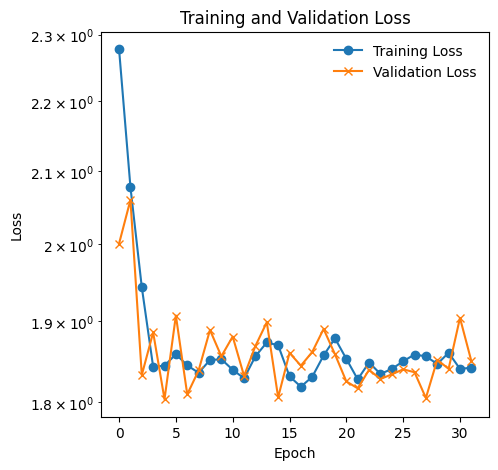

In [23]:
losses = utilities.extract_training_losses(model_trainer.metadata)
fig, ax = plots.plot_training_validation_loss(losses['avg_train_losses'], losses['avg_val_losses'])
ax.set_yscale('log')

In [24]:
encoded = chembl_mini.tokenizer.encode("C")
encoded_1h = chembl_mini.encoding_to_one_hot(encoded)
print(encoded)
print(encoded_1h.argmax())

[24]
tensor(24)


In [25]:
pred_raw = model(encoded_1h)


RuntimeError: input.size(-1) must be equal to input_size. Expected 1029, got 1

In [ ]:
pred_raw.shape

torch.Size([1, 1029])

In [ ]:
tokens = pred_raw.argmax(1).tolist()

In [ ]:
print(chembl_mini.tokenizer.decode(tokens))

CN2CCN


In [ ]:
chembl_mini.tokenizer.decode(chembl_mini[0][0].argmax(1).tolist())

'Cc1cc ( - c2csc ( N = C ( N ) N ) n2 ) cn1 C [UNK] EOM [UNK] CC [ C @ H ] ( C ) [ C'

In [ ]:
chembl_mini.tokenizer.decode(chembl_mini[0][1].argmax(0).tolist())

'@'